In [53]:
using LinearAlgebra
using DataFrames
using JuMP, Ipopt

In [54]:
BranchData = DataFrame(From = [ 1, 1, 2, 3, 3, 4], To = [ 2, 3, 4, 4, 5, 5], 
    R = [ 0.0, 0.023, 0.006, 0.020, 0.0, 0.0], X = [ 0.3, 0.145, 0.032, 0.260, 0.320, 0.500], 
    Gsh = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Bsh = [ 0.0, 0.040, 0.010, 0.0, 0.0, 0.0], 
    T = [ 1.0, 1.0, 1.0, 1.0, 0.98,1], Tl = [1.0, 1.0, 1.0, 1.0, 0.95, 1.0], Tu = [1.0, 1.0, 1.0, 1.0, 1.05, 1.0],
    ϕ = [ 0.0, 0.0, 0.0, -3.0, 0.0, 0.0], ϕl = [ 0.0, 0.0, 0.0, -30.0, 0.0, 0.0], ϕu = [ 0.0, 0.0, 0.0, 30.0, 0.0, 0.0]
    );
ZshB = [ 0.0+0.0*im 0.0+0.3*im 0.05+0.0*im 0.0+0.0*im 0.0+0.0*im]; 
GshB = [ 0.0 0.0 0.05 0.0 0.0];
BshB = [ 0.0 0.3 0.0 0.0 0.0];
BusNum = 5;
nLine= nrow(BranchData);
#From = BranchData.From;
#To = BranchData.To;

In [55]:
R = BranchData.R; X = BranchData.X; Bsh = BranchData.Bsh; T = BranchData.T; ϕ = BranchData.ϕ;
Y = conj((R + X*im).^-1); G = real(Y); B = imag(Y);
insertcols!(BranchData, 4, Y = round.(Y,digits = 3));
insertcols!(BranchData, 5, G = round.(G,digits = 3));
insertcols!(BranchData, 6, B = round.(B,digits = 3));
select!(BranchData, Not(:R));
select!(BranchData, Not(:X));

In [56]:
BusData = DataFrame(Bus = [ 1, 2, 3, 4, 5], 
    PL = [ 0.0, 0.0, 0.0, 0.90, 0.239], QL = [ 0.0, 0.0, 0.0, 0.400, 0.129], 
    Vmin = [ 1.0, 0.95, 0.95, 0.95, 0.95], Vmax = [ 1.0, 1.05, 1.05, 1.05, 1.05]
    );
GenData = DataFrame(Bus = [ 1, 2, 3, 4, 5], 
    PGmin = [ -Inf, 0.0, 0.10, 0.05, 0.0], PGmax = [ Inf, 0.0, 0.40, 0.40, 0.0], 
    QGmin = [ -Inf, 0.0, -0.2, -0.2, 0.0], QGmax = [ Inf, 0.0, 0.30, 0.20, 0.0]
    );

In [57]:
PgL = Dict{Int64, Float64}();
PgU = Dict{Int64, Float64}();
QgL = Dict{Int64, Float64}();
QgU = Dict{Int64, Float64}();
GenBus = Dict{Int64, Int64}();
for i in 1:size(GenData)[1]
    GenBus[GenData.Bus[i]] = GenData.Bus[i]
    PgL[GenData.Bus[i]]= GenData.PGmin[i]
    PgU[GenData.Bus[i]]= GenData.PGmax[i]
    QgL[GenData.Bus[i]]= GenData.QGmin[i]
    QgU[GenData.Bus[i]]= GenData.QGmax[i]
end

In [58]:
PL = Dict{Int64, Float64}();
QL = Dict{Int64, Float64}();
Vmin = Dict{Int64, Float64}();
Vmax = Dict{Int64, Float64}();
LoadBus = Dict{Int64, Int64}();
for i in 1:size(BusData)[1]
    PL[BusData.Bus[i]]= BusData.PL[i]
    QL[BusData.Bus[i]]= BusData.QL[i]
    Vmin[BusData.Bus[i]]= BusData.Vmin[i]
    Vmax[BusData.Bus[i]]= BusData.Vmax[i]
    LoadBus[BusData.Bus[i]]= BusData.Bus[i]
end

In [59]:
y = Dict{Tuple{Int64, Int64}, ComplexF64}();
g = Dict{Tuple{Int64, Int64}, Float64}();
b = Dict{Tuple{Int64, Int64}, Float64}();
bsh = Dict{Tuple{Int64, Int64}, Float64}();
Tap = Dict{Tuple{Int64, Int64}, Float64}(); 
TapL = Dict{Tuple{Int64, Int64}, Float64}(); 
TapU = Dict{Tuple{Int64, Int64}, Float64}();
Phase = Dict{Tuple{Int64, Int64}, Float64}();
PhaseL = Dict{Tuple{Int64, Int64}, Float64}();
PhaseU = Dict{Tuple{Int64, Int64}, Float64}();


for i in 1:size(BranchData)[1]
    y[(BranchData.From[i], BranchData.To[i])]= BranchData.Y[i]
    g[(BranchData.From[i], BranchData.To[i])]= BranchData.G[i]
    b[(BranchData.From[i], BranchData.To[i])]= BranchData.B[i]
    bsh[(BranchData.From[i], BranchData.To[i])]= BranchData.Bsh[i]
    Tap[(BranchData.From[i], BranchData.To[i])]= BranchData.T[i]
    TapL[(BranchData.From[i], BranchData.To[i])]= BranchData.Tl[i]
    TapU[(BranchData.From[i], BranchData.To[i])]= BranchData.Tu[i]
    Phase[(BranchData.From[i], BranchData.To[i])]= BranchData.ϕ[i]
    PhaseL[(BranchData.From[i], BranchData.To[i])]= BranchData.ϕl[i]
    PhaseU[(BranchData.From[i], BranchData.To[i])]= BranchData.ϕu[i]
end



In [38]:
model = nothing
model = Model(with_optimizer(Ipopt.Optimizer, linear_solver = "mumps", 
        derivative_test = "second-order",check_derivatives_for_naninf = "yes",
        print_info_string="yes"))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [39]:
@variable(model, T[i = keys(y)]);
@variable(model, ϕ[i = keys(y)]);
@variable(model, P[1:BusNum,1:BusNum]);
@variable(model, Pg[1:BusNum]);
#@variable(model, Qg[1:BusNum]);
@variable(model, V[1:BusNum],start = 1);
@variable(model, E[1:BusNum],start = 1);
@variable(model, F[1:BusNum],start = 0);

In [40]:
for (i,j) in keys(y)
    set_start_value(T[(i,j)], Tap[(i,j)])
    set_start_value(ϕ[(i,j)], Phase[(i,j)] * π/180)
end

In [41]:
set_upper_bound(T[(3,5)], TapU[(3,5)] );
set_lower_bound(T[(3,5)], TapL[(3,5)] );

for (i,j) in  filter(x -> x ≠ (3,5), collect(keys(y)))
    fix(T[(i,j)], TapU[(i,j)]);
    fix(T[(i,j)], TapL[(i,j)]);
end

In [42]:
set_upper_bound(ϕ[(3,4)], PhaseU[(3,4)] * π/180);
set_lower_bound(ϕ[(3,4)], PhaseL[(3,4)] * π/180);

for (i,j) in  filter(x -> x ≠ (3,4), collect(keys(y)))
    fix(ϕ[(i,j)], Phase[(i,j)] * π/180)
    fix(ϕ[(i,j)], Phase[(i,j)] * π/180)
end

In [43]:
for i in keys(GenBus)
    set_upper_bound(Pg[i], PgU[i]);
    set_lower_bound(Pg[i], PgL[i]);
#    set_upper_bound(Qg[i], QgU[i]);
#    set_lower_bound(Qg[i], QgL[i]);
end
delete_upper_bound(Pg[2])
delete_lower_bound(Pg[2])
delete_upper_bound(Pg[5])
delete_lower_bound(Pg[5])
fix(Pg[2],0)
fix(Pg[5],0)
#delete_upper_bound(Qg[2])
#delete_lower_bound(Qg[2])
#delete_upper_bound(Qg[5])
#delete_lower_bound(Qg[5])
#fix(Qg[2],0)
#fix(Qg[5],0)

In [44]:
for i in 2:BusNum
    set_upper_bound(V[i], Vmax[i]);
    set_lower_bound(V[i], Vmin[i]);
#    set_upper_bound(E[i],  1.5);
#    set_lower_bound(E[i], -1.5);
#    set_upper_bound(F[i],  1.5 );
#    set_lower_bound(F[i], -1.5);
    
end

In [45]:
fix(V[1],1)
#fix(E[1],1)
#fix(F[1],0)

In [46]:
#@NLconstraint(model,voltage[i = 1:BusNum], V[i]*V[i] == (E[i]*E[i]+F[i]*F[i] ) );

In [47]:
#@constraint(model,ActivePowerLogic[(i,j) = keys(y)], P[i,j] == -P[j,i]);

In [48]:
@objective(model, Min, 0.35*Pg[1] + 0.2*Pg[3] + 0.4*Pg[3]*Pg[3] + 0.3*Pg[4] + 0.5*Pg[4]*Pg[4]);

In [49]:
@NLexpression(model, ActivePFij[(i,j) = keys(y)], 
  (1/(T[(i,j)]*T[(i,j)]))*( g[(i,j)]                                       )*(E[i]*E[i] +  F[i]*F[i]) +
  (1/(T[(i,j)]         ))*(-g[(i,j)]*cos(ϕ[(i,j)]) + b[(i,j)]*sin(ϕ[(i,j)]))*(E[i]*E[j] +  F[i]*F[j]) +
  (1/(T[(i,j)]         ))*( g[(i,j)]*sin(ϕ[(i,j)]) + b[(i,j)]*cos(ϕ[(i,j)]))*(E[i]*F[j] -  E[i]*F[j])
                            );

In [50]:
@NLexpression(model, ActivePFji[(i,j) = keys(y)],
                          ( g[(i,j)]                                       )*(E[j]*E[j] +  F[j]*F[j]) +
  (1/(T[(i,j)]         ))*(-g[(i,j)]*cos(ϕ[(i,j)]) - b[(i,j)]*sin(ϕ[(i,j)]))*(E[i]*E[j] +  F[i]*F[j]) +
  (1/(T[(i,j)]         ))*( g[(i,j)]*sin(ϕ[(i,j)]) - b[(i,j)]*cos(ϕ[(i,j)]))*(E[i]*F[j] -  E[i]*F[j])
                            );

In [51]:
@NLconstraint(model, ActiveBranch[i = 1:BusNum],Pg[i]-PL[i] == 
sum(ActivePFij[(i,j)] for (i,j) in keys(filter(p -> p.first[1] == i,g))) + 
sum(ActivePFji[(i,j)] for (i,j) in keys(filter(p -> p.first[1] == i,g)))
    ); 

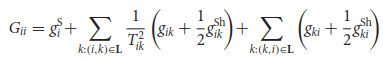

In [52]:
optimize!(model)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Starting derivative checker for first derivatives.

Starting derivative checker for second derivatives.


No errors detected by derivative checker.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       66

Total number of variables............................:       44
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        8
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
  

In [197]:
model

A JuMP Model
Minimization problem with:
Variables: 57
Objective function type: GenericQuadExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 6 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 15 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 17 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 17 constraints
Nonlinear: 11 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Ipopt
Names registered in the model: ActiveBranch, ActivePFij, ActivePFji, ActivePowerLogic, E, F, P, Pg, T, V, voltage, ϕ

In [60]:
model2 = nothing
model2 = Model(with_optimizer(Ipopt.Optimizer, linear_solver = "mumps", 
        derivative_test = "second-order",check_derivatives_for_naninf = "yes",
        print_info_string="yes"))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [61]:
@NLexpression(model2,Gself[i = 1:5],GshB[i] + 
sum( (1/(T[(i,j)]*T[(i,j)])) * (g[(i,j)] + 0.5*gsh[(i,j)]) 
    for (i,j) in keys(filter(((k1,k2),v) -> k1 == i,g))) +
sum((g[(j,i)] + 0.5 * gsh[(j,i)]) 
    for (j,i) in keys(filter(((k1,k2),v) -> k2 == i,g)))
    );

┌ Warning: In `filter(f, dict)`, `f` is now passed a single pair instead of two arguments.
│   caller = top-level scope at parse_nlp.jl:243
└ @ Core C:\Users\cilli\.julia\packages\JuMP\MsUSY\src\parse_nlp.jl:243


ArgumentError: ArgumentError: invalid index: (1, 2) of type Tuple{Int64,Int64}

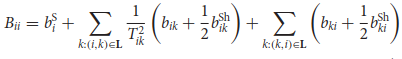

In [ ]:
@NLexpression(model2,Bself[i = 1:5],BshB[i] + 
sum(1/(T[(i,j)]*T[(i,j)] )* (b[(i,j)] + 0.5*bsh[(i,j)])
        for (i,j) in keys(filter(((k1,k2),v) -> k1 == i,b))) +
sum((b[(j,i)] + 0.5*bsh[(j,i)]) 
        for (j,i) in keys(filter(((k1,k2),v) -> k2 == i,b))) 
    );

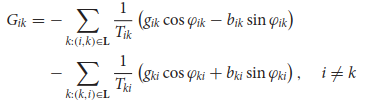

In [ ]:
@NLexpression(model2,Gtrans[i = 1:5,j = 1:5],
-sum( 1/(T[(i,j)])*(g[(i,j)]*cos(ϕ[(i,j)]) - b[(i,j)]*sin(ϕ[(i,j)])) 
        for (i,j) in keys(filter(((k1,k2),v) -> k1 == i && k2 == j,g)))
-sum( 1/(T[(j,i)])*(g[(j,i)]*cos(ϕ[(j,i)]) + b[(j,i)]*sin(ϕ[(j,i)])) 
        for (j,i) in keys(filter(((k1,k2),v) -> k2 == i && k1 == j,g)))
    );

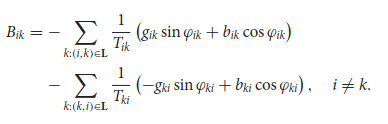

In [ ]:
@NLexpression(model2,Btrans[i = 1:5,j = 1:5],
-sum( 1/(T[(i,j)])*(g[(i,j)]*sin(ϕ[(i,j)]) + b[(i,j)]*cos(ϕ[(i,j)])) 
        for (i,j) in keys(filter(((k1,k2),v) -> k1 == i && k2 == j,b)))
-sum( 1/(T[(j,i)])*(-g[(j,i)]*sin(ϕ[(j,i)]) + b[(j,i)]*cos(ϕ[(j,i)])) 
        for (j,i) in keys(filter(((k1,k2),v) ->k2 == i && k1 == j,b)))
    );

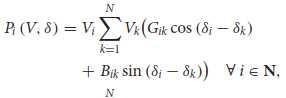

In [ ]:
@NLconstraint(model2, ActivePF[i = 1:BusNum],Pg[i]-PL[i] == 
V[i]*( 
V[i]*( (Gself[i])*cos(δ[i] - δ[i]) + (Bself[i])*sin(δ[i] - δ[i]) ) +
sum( V[j]*( (Gtrans[i,j])*cos(δ[i] - δ[j]) + (Btrans[i,j])*sin(δ[i] - δ[j])) 
for j in  filter(x -> x ≠ i,reduce(hcat, getindex.( [j for j in collect(keys(filter(((k1,k2),v) -> k1 == i || k2 == i,g)))],k) for k in eachindex([j for j in collect(keys(filter(((k1,k2),v) -> k1 == i || k2 == i,g)))][1])) )
    )
     )
      );

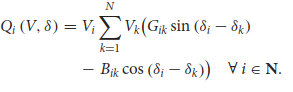

In [ ]:
@NLconstraint(model2, ReActivePF[i = 1:BusNum],Qg[i]-QL[i] == 
V[i]*( 
V[i]*( (Gself[i])*sin(δ[i] - δ[i]) - (Bself[i])*cos(δ[i] - δ[i]) ) +
sum( V[j]*( (Gtrans[i,j])*sin(δ[i] - δ[j]) - (Btrans[i,j])*cos(δ[i] - δ[j])) 

for j in  filter(x -> x ≠ i,reduce(hcat, getindex.( [j for j in collect(keys(filter(((k1,k2),v) -> k1 == i || k2 == i,g)))],k) for k in eachindex([j for j in collect(keys(filter(((k1,k2),v) -> k1 == i || k2 == i,g)))][1])) )
    )
     )
      );

In [ ]:
optimize!(model2)

In [ ]:
key1 = [ 1, 1, 2, 3, 3, 4]; key2 = [ 2, 3, 4, 4, 5, 5]
value = [0.3, 0.145, 0.032, 0.260, 0.320, 0.500]
Data = Dict{Tuple{Int64, Int64}, Float64}();
for i in 1:6
    Data[(key1[i],key2[i])] = value[i]    
end
filter(((k1,k2),v) -> k1 == 1, Data)

In [ ]:
key1 = [ 1, 1, 2, 3, 3, 4]; key2 = [ 2, 3, 4, 4, 5, 5]
value = [0.3, 0.145, 0.032, 0.260, 0.320, 0.500]
Data = Dict{Tuple{Int64, Int64}, Float64}();
for i in 1:6
    Data[(key1[i],key2[i])] = value[i]    
end
filter(p -> p.first[2] == 2, Data)

In [ ]:
 c = [1+8im;2-4im]

In [ ]:
conj(c)

In [ ]:
model